In [2]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers
import helpers
import wrangle

# Code
This is the scratchpad area of the notebook.  If you are interested in the code that went into building the clustering pipeline feel free to look through it.  However, a more detailed demonstration and exploration is available in the next section.

In [3]:
df = wrangle.wrangle_data('both')
train, test , validate = helpers.prep.train_test_validate_split(df)

In [4]:
class FlavorProfile:

    def __init__(self, **kwargs):
        defaultKwargs = {
            'features' : ['volatile_acidity','chlorides','residual_sugar','alcohol'],
            'random_state': 8,
            'k' : 4
        }
        kwargs = { **defaultKwargs, **kwargs }
        
        self.features = kwargs['features']
        self.random_state = kwargs['random_state']
        self.n_clusters = kwargs['k']
    
    def fit(self, train):
        self.train = train
        self.fit_scaler()
        self.fit_clusterer()
        return self

    def fit_scaler(self):
        self.scaler = helpers.prep.train_scaler(self.train[self.features])
        self.scaled_train = self.train.copy()
        self.scaled_train[self.features] = self.scaler.transform(self.train[self.features])

    def fit_clusterer(self):
        self.clusterer = helpers.cluster.build_kmeans_clusterer(df=self.scaled_train, cols=self.features, k=self.n_clusters, random_state=self.random_state)

    def predict(self, df):
        temp_df = df.copy()
        temp_df[self.features] = self.scaler.transform(temp_df[self.features])
        y = self.clusterer.predict(temp_df[self.features])
        return y


# Flavor Profiles

In [9]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers
import helpers
import wrangle

# Get the dataframe
df = wrangle.wrangle_data('both')
train, test , validate = helpers.prep.train_test_validate_split(df)


In our research we found that certain variables were associated with certain flavors of a wine.  For example, a high volatile acidity content would cause a wine to have a more vinegar-like flavor, a high sugar content led to a sweeter wine, higher chlorides meant more saltiness, and the %ABV led directly to the strength of a wine.  So to capture that information we used a K-means clustering model trained on those variables to develop what we call the wine's "flavor profile".

In [30]:
# Import the helper class used to quickly build and train the model
from model import FlavorProfile

# Train the class with default options on the training data only
flavor = FlavorProfile()
flavor.fit(train)

# Use the trained model to create a new column in each of the sample sets.
train['flavor_profile'] = flavor.predict(train)
test['flavor_profile'] = flavor.predict(test)
validate['flavor_profile'] = flavor.predict(validate)

When we compared the distribution of quality scores across the flavor profiles created we discovered that there was a clear preference among the testers involved in the creation of this dataset. Flavor Profile 0 contained the most high quality wines, while Flavor Profile 3 contained the most low quality wines.

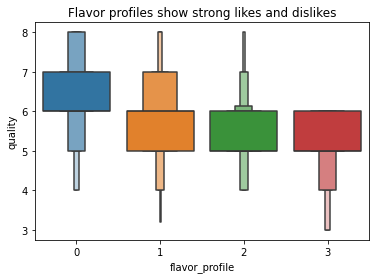

In [31]:
sns.boxenplot(data=train, x='flavor_profile', y='quality', showfliers=False)
plt.title('Flavor profiles show strong likes and dislikes')
plt.show()

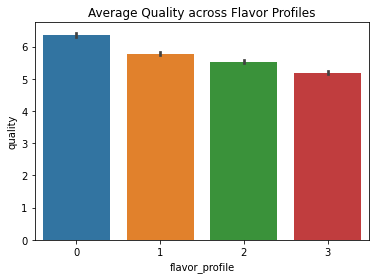

In [19]:
sns.barplot(data= train, x='flavor_profile', y='quality').set(title='Average Quality across Flavor Profiles')
plt.show()

    Note: Even though the profiles appear to be ranked, this is a fluke.  The numbers were randomly assigned.

### Visualizing the clusters

Because chlorides did not introduce much variablity into the 4-dimensional space in which the clustering model was trained, it is still possible to see the clusters in action by plotting the wines in a 3d space using the remaining features.  

In [37]:
import plotly.express as px
train['flavor_profile'] = train['flavor_profile'].astype('string')
fig = px.scatter_3d(train, 
                    x = 'volatile_acidity',
                    y = 'alcohol',
                    z = 'residual_sugar',
                    color='flavor_profile',
                    )
fig.update_layout(width=700, height=500)
fig.update_layout(margin={"r":0,"t":0,"l":10,"b":0})
fig.show()

The plotly chart above does not render on github, so here is a still-image alternative:  
![Flavor Profiles Chart](./img/plotly_flavor_profiles.png)

# Key takeaways

The clusters built using this method seems to be a good predictor of quality. Also, we can foresee this clustering model being useful for marketing purposes by potentially matching customers to their preferred flavor profile.

Because the EU requires most of the features used in this model to be included in the certificate of import, a similar model could be built without the need to collect any additional data.